In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
%matplotlib inline

In [2]:
user_list            = pd.read_csv("../input/purchase-coupons-data/user_list.csv")
coupon_area_train    = pd.read_csv("../input/purchase-coupons-data/coupon_area_train.csv")
coupon_detail_train  = pd.read_csv("../input/purchase-coupons-data/coupon_detail_train.csv")
coupon_list_train    = pd.read_csv("../input/purchase-coupons-data/coupon_list_train.csv")
coupon_visit_train   = pd.read_csv("../input/purchase-coupons-visit/coupon_visit_train.csv")
#prefecture_locations = pd.read_csv("../input/purchase-coupons-data/prefecture_locations.csv")

In [3]:
import json

# read file
with open('../input/purchase-coupons-data/translations.json', 'r') as myfile:
    data=myfile.read()

# parse file
translations = json.loads(data)

In [4]:
user_list['PREF_NAME'] = user_list['PREF_NAME'].map(translations)
coupon_area_train['PREF_NAME'] = coupon_area_train['PREF_NAME'].map(translations)
coupon_area_train['SMALL_AREA_NAME'] = coupon_area_train['SMALL_AREA_NAME'].map(translations)
coupon_detail_train['SMALL_AREA_NAME'] = coupon_detail_train['SMALL_AREA_NAME'].map(translations)
#prefecture_locations['PREF_NAME'] = prefecture_locations['PREF_NAME'].map(translations)
#prefecture_locations['PREFECTUAL_OFFICE'] = prefecture_locations['PREFECTUAL_OFFICE'].map(translations)

In [5]:
coupon_list_english = ['CAPSULE_TEXT','GENRE_NAME','large_area_name','ken_name','ken_name','small_area_name']
coupon_list_train[coupon_list_english] = coupon_list_train[coupon_list_english].apply(lambda x: x.map(translations))

In [6]:
user_list.head()

,REG_DATE,SEX_ID,AGE,WITHDRAW_DATE,PREF_NAME,USER_ID_hash
0,2012-03-28 14:14:18,f,25,NaN,NaN,d9dca3cb44bab12ba313eaa681f663eb
1,2011-05-18 00:41:48,f,34,NaN,Tokyo,560574a339f1b25e57b0221e486907ed
2,2011-06-13 16:36:58,m,41,NaN,Aichi Prefecture,e66ae91b978b3229f8fd858c80615b73
3,2012-02-08 12:56:15,m,25,NaN,NaN,43fc18f32eafb05713ec02935e2c2825
4,2011-05-22 23:43:56,m,62,NaN,Kanagawa Prefecture,dc6df8aa860f8db0d710ce9d4839840f


In [7]:
coupon_area_train.head()

,SMALL_AREA_NAME,PREF_NAME,COUPON_ID_hash
0,Saitama,Saitama Prefecture,6b263844241eea98c5a97f1335ea82af
1,Chiba,Chiba Prefecture,cc031f250e8bad1e24060263b9fc0ddd
2,Chiba,Chiba Prefecture,ba5e9b7453ca52ff711635a5d2e8102d
3,Chiba,Chiba Prefecture,3e1ffbedca3569f9e8032d401e8cb4e6
4,Chiba,Chiba Prefecture,782934b6c815b4030ea204eef7d4a734


In [8]:
coupon_detail_train.head()

,ITEM_COUNT,I_DATE,SMALL_AREA_NAME,PURCHASEID_hash,USER_ID_hash,COUPON_ID_hash
0,1,2012-03-28 15:06:06,Hyogo,c820a8882374a4e472f0984a8825893f,d9dca3cb44bab12ba313eaa681f663eb,34c48f84026e08355dc3bd19b427f09a
1,1,2011-07-04 23:52:54,"Ginza Shinbashi, Tokyo, Ueno",1b4eb2435421ede98c8931c42e8220ec,560574a339f1b25e57b0221e486907ed,767673b7a777854a92b73b0934ddfae7
2,1,2011-07-16 00:52:49,"Ebisu, Meguro Shinagawa",36b5f9ba46c44b65587d0b16f2e4c77f,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
3,1,2011-07-16 00:54:53,"Ebisu, Meguro Shinagawa",2f30f46937cc9004774e576914b2aa1a,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
4,1,2011-07-16 00:55:52,"Ebisu, Meguro Shinagawa",4d000c64a55ac573d0ae1a8f03677f50,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2


In [9]:
coupon_visit_train.count()

PURCHASE_FLG           2833180
I_DATE                 2833180
PAGE_SERIAL            2833180
REFERRER_hash          2833180
VIEW_COUPON_ID_hash    2833180
USER_ID_hash           2833180
SESSION_ID_hash        2833180
PURCHASEID_hash         122389
dtype: int64

### Exploratory Analysis

In [10]:
coupon_visit_train.count()

PURCHASE_FLG           2833180
I_DATE                 2833180
PAGE_SERIAL            2833180
REFERRER_hash          2833180
VIEW_COUPON_ID_hash    2833180
USER_ID_hash           2833180
SESSION_ID_hash        2833180
PURCHASEID_hash         122389
dtype: int64

In [11]:
visit_coupon = pd.merge(coupon_visit_train, coupon_list_train, how = 'inner',left_on="VIEW_COUPON_ID_hash", right_on="COUPON_ID_hash")

In [12]:
visit_coupon.count().head()

PURCHASE_FLG           2517206
I_DATE                 2517206
PAGE_SERIAL            2517206
REFERRER_hash          2517206
VIEW_COUPON_ID_hash    2517206
dtype: int64

In [13]:
user_visit_coupon = pd.merge(visit_coupon, user_list, how = 'left', left_on="USER_ID_hash", right_on="USER_ID_hash")

In [14]:
user_visit_coupon.describe()

,PURCHASE_FLG,PAGE_SERIAL,PRICE_RATE,CATALOG_PRICE,DISCOUNT_PRICE,DISPPERIOD,VALIDPERIOD,USABLE_DATE_MON,USABLE_DATE_TUE,USABLE_DATE_WED,USABLE_DATE_THU,USABLE_DATE_FRI,USABLE_DATE_SAT,USABLE_DATE_SUN,USABLE_DATE_HOLIDAY,USABLE_DATE_BEFORE_HOLIDAY,AGE
count,2.517206e+06,2.517206e+06,2.517206e+06,2.517206e+06,2.517206e+06,2.517206e+06,1.744733e+06,1.538109e+06,1.538109e+06,1.538109e+06,1.538109e+06,1.538109e+06,1.538109e+06,1.538109e+06,1.538109e+06,1.538109e+06,2.517206e+06
mean,4.862097e-02,7.636990e+00,5.833960e+01,1.080425e+04,4.279764e+03,3.786802e+00,1.256226e+02,9.679815e-01,9.828231e-01,9.913420e-01,9.945030e-01,1.017453e+00,1.136544e+00,9.327486e-01,9.593182e-01,1.106846e+00,4.730055e+01
std,2.150744e-01,1.226163e+01,1.224105e+01,1.422837e+04,5.486774e+03,3.000429e+00,4.815364e+01,2.445966e-01,2.275536e-01,1.809349e-01,1.654044e-01,3.382537e-01,6.402163e-01,4.213224e-01,4.046429e-01,5.986488e-01,1.123943e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01
25%,0.000000e+00,2.000000e+00,5.000000e+01,3.249000e+03,1.470000e+03,3.000000e+00,8.900000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.900000e+01
50%,0.000000e+00,4.000000e+00,5.200000e+01,6.000000e+03,2.500000e+03,3.000000e+00,1.320000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.800000e+01
75%,0.000000e+00,9.000000e+00,6.400000e+01,1.320000e+04,4.900000e+03,4.000000e+00,1.760000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.500000e+01
max,1.000000e+00,1.368000e+03,1.000000e+02,6.800000e+05,1.000000e+05,3.600000e+01,1.790000e+02,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,8.000000e+01


In [15]:
# Serching null Values 
user_visit_coupon.isnull().sum()

PURCHASE_FLG                        0
I_DATE                              0
PAGE_SERIAL                         0
REFERRER_hash                       0
VIEW_COUPON_ID_hash                 0
USER_ID_hash                        0
SESSION_ID_hash                     0
PURCHASEID_hash               2394817
CAPSULE_TEXT                        0
GENRE_NAME                          0
PRICE_RATE                          0
CATALOG_PRICE                       0
DISCOUNT_PRICE                      0
DISPFROM                            0
DISPEND                             0
DISPPERIOD                          0
VALIDFROM                      772473
VALIDEND                       772473
VALIDPERIOD                    772473
USABLE_DATE_MON                979097
USABLE_DATE_TUE                979097
USABLE_DATE_WED                979097
USABLE_DATE_THU                979097
USABLE_DATE_FRI                979097
USABLE_DATE_SAT                979097
USABLE_DATE_SUN                979097
USABLE_DATE_

In [16]:
#Converting dates to datetime
user_visit_coupon['DISPFROM'] = pd.to_datetime(user_visit_coupon['DISPFROM'], infer_datetime_format=True)
user_visit_coupon['DISPEND'] = pd.to_datetime(user_visit_coupon['DISPEND'], infer_datetime_format=True)
user_visit_coupon['VALIDFROM'] = pd.to_datetime(user_visit_coupon['VALIDFROM'], infer_datetime_format=True)
user_visit_coupon['VALIDEND'] = pd.to_datetime(user_visit_coupon['VALIDEND'], infer_datetime_format=True)
user_visit_coupon['WITHDRAW_DATE'] = pd.to_datetime(user_visit_coupon['WITHDRAW_DATE'], infer_datetime_format=True)
user_visit_coupon['REG_DATE'] = pd.to_datetime(user_visit_coupon['REG_DATE'], infer_datetime_format=True)


In [17]:
#Extracting year, month and days in number from dates
user_visit_coupon_DISPFROM_year      = user_visit_coupon['DISPFROM'].dt.year
user_visit_coupon_DISPFROM_month     = user_visit_coupon['DISPFROM'].dt.month
user_visit_coupon_DISPFROM_day       = user_visit_coupon['DISPFROM'].dt.day
user_visit_coupon_DISPEND_year       = user_visit_coupon['DISPEND'].dt.year
user_visit_coupon_DISPEND_month      = user_visit_coupon['DISPEND'].dt.month
user_visit_coupon_DISPEND_day        = user_visit_coupon['DISPEND'].dt.day
user_visit_coupon_VALIDFROM_year     = user_visit_coupon['VALIDFROM'].dt.year
user_visit_coupon_VALIDFROM_month    = user_visit_coupon['VALIDFROM'].dt.month
user_visit_coupon_VALIDFROM_day      = user_visit_coupon['VALIDFROM'].dt.day
user_visit_coupon_VALIDEND_year      = user_visit_coupon['VALIDEND'].dt.year
user_visit_coupon_VALIDEND_month     = user_visit_coupon['VALIDEND'].dt.month
user_visit_coupon_VALIDEND_day       = user_visit_coupon['VALIDEND'].dt.day
user_visit_coupon_REG_DATE_DATE_year   = user_visit_coupon['REG_DATE'].dt.year
user_visit_coupon_REG_DATE_DATE_month  = user_visit_coupon['REG_DATE'].dt.month
user_visit_coupon_REG_DATE_DATE_day    = user_visit_coupon['REG_DATE'].dt.day
user_visit_coupon_WITHDRAW_DATE_year   = user_visit_coupon['WITHDRAW_DATE'].dt.year
user_visit_coupon_WITHDRAW_DATE_month  = user_visit_coupon['WITHDRAW_DATE'].dt.month
user_visit_coupon_WITHDRAW_DATE_day    = user_visit_coupon['WITHDRAW_DATE'].dt.day

In [18]:
user_visit_coupon = user_visit_coupon.drop(['DISPFROM', 'DISPEND', 'VALIDFROM', 'VALIDEND', 'WITHDRAW_DATE','REG_DATE'],axis = 1)

In [19]:
#Replacing null values 
numerical_columns = user_visit_coupon.select_dtypes(np.number).columns
user_visit_coupon[numerical_columns] = user_visit_coupon[numerical_columns].fillna(0)
user_visit_coupon['PREF_NAME'] =  user_visit_coupon['PREF_NAME'].fillna('unknown')
user_visit_coupon.isnull().sum()

PURCHASE_FLG                        0
I_DATE                              0
PAGE_SERIAL                         0
REFERRER_hash                       0
VIEW_COUPON_ID_hash                 0
USER_ID_hash                        0
SESSION_ID_hash                     0
PURCHASEID_hash               2394817
CAPSULE_TEXT                        0
GENRE_NAME                          0
PRICE_RATE                          0
CATALOG_PRICE                       0
DISCOUNT_PRICE                      0
DISPPERIOD                          0
VALIDPERIOD                         0
USABLE_DATE_MON                     0
USABLE_DATE_TUE                     0
USABLE_DATE_WED                     0
USABLE_DATE_THU                     0
USABLE_DATE_FRI                     0
USABLE_DATE_SAT                     0
USABLE_DATE_SUN                     0
USABLE_DATE_HOLIDAY                 0
USABLE_DATE_BEFORE_HOLIDAY          0
large_area_name                     0
ken_name                            0
small_area_n

In [20]:
user_visit_coupon.AGE.unique()

array([25, 50, 49, 29, 33, 59, 43, 34, 44, 38, 52, 47, 55, 30, 57, 35, 64,
       42, 39, 53, 36, 54, 56, 45, 58, 61, 48, 27, 41, 62, 37, 46, 32, 60,
       28, 65, 21, 51, 40, 69, 79, 31, 71, 63, 26, 66, 24, 23, 72, 70, 73,
       68, 75, 77, 67, 22, 76, 20, 78, 74, 18, 80, 17, 19, 15, 16])

In [21]:
user_visit_coupon.AGE.min(),user_visit_coupon.AGE.max()

(15, 80)

In [22]:
#We put the age column in buckets to better visualize the ranges 
bins = [15, 30, 40, 50, 60,70, 80]
labels = ['15-29', '30-39', '40-49', '50-59', '60-69', '70-80']
user_visit_coupon['agelabel'] = pd.cut(user_visit_coupon.AGE , bins, labels = labels,include_lowest = True)

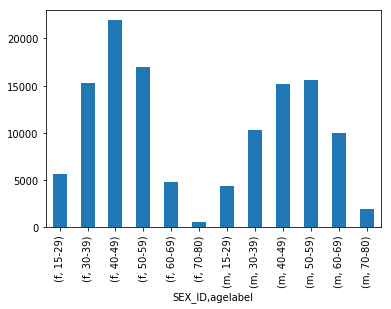

In [23]:
#Chart to identify the age ranges where coupons are used
PURCHASE_POSITIVE = user_visit_coupon[user_visit_coupon['PURCHASE_FLG']==1]
gender_age = PURCHASE_POSITIVE.groupby(['SEX_ID','agelabel']).size()
gender_age.plot.bar()

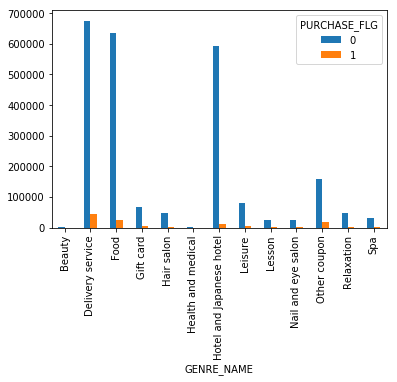

In [24]:
#Identify in which category of coupons there is more use of coupons
pd.crosstab(user_visit_coupon['GENRE_NAME'],user_visit_coupon['PURCHASE_FLG']).plot.bar()

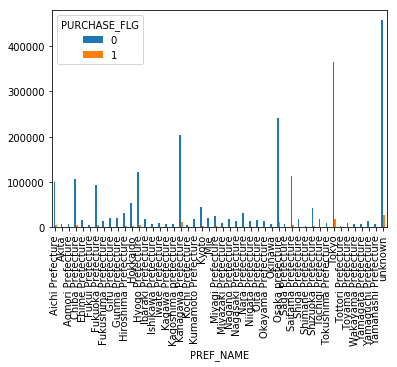

In [25]:
#Trying to see the largest number of purchases according to the PREF_NAME
pd.crosstab(user_visit_coupon['PREF_NAME'],user_visit_coupon['PURCHASE_FLG']).plot.bar()

In [26]:
#Percentage of Actual Discount on Price
user_visit_coupon['PERCENTAGE_DISCOUNT'] = 100 - user_visit_coupon['PRICE_RATE']

In [27]:
user_visit_coupon[['PRICE_RATE','PERCENTAGE_DISCOUNT','CATALOG_PRICE','DISCOUNT_PRICE']].head()

,PRICE_RATE,PERCENTAGE_DISCOUNT,CATALOG_PRICE,DISCOUNT_PRICE
0,78,22,7200,1575
1,78,22,7200,1575
2,78,22,7200,1575
3,78,22,7200,1575
4,78,22,7200,1575


In [28]:
user_visit_coupon  = user_visit_coupon.drop(['I_DATE', 'PAGE_SERIAL', 'REFERRER_hash',
       'VIEW_COUPON_ID_hash', 'USER_ID_hash', 'SESSION_ID_hash',
       'PURCHASEID_hash','CAPSULE_TEXT','PRICE_RATE','AGE'],axis=1)


In [29]:
#I don't know exactly what 2 means in those kind of features...
#Let's take the value 2 like - Available with restrictions related with the location according to kaggle discussions
user_visit_coupon.USABLE_DATE_FRI.unique()

array([0., 1., 2.])

**Feature engineering**

In [30]:
### convert categoricals to OneHotEncoder form
categoricals = ['GENRE_NAME', 'large_area_name', 'ken_name', 'small_area_name', 'agelabel','SEX_ID','PREF_NAME']
combined_categoricals = user_visit_coupon[categoricals]
combined_categoricals = pd.get_dummies(combined_categoricals,dummy_na=False)

In [31]:
user_visit_coupon = user_visit_coupon.drop(['GENRE_NAME', 'large_area_name', 'ken_name', 'small_area_name', 'agelabel','SEX_ID','PREF_NAME','COUPON_ID_hash'],axis = 1)

In [32]:
#Putting together the categorical columns
user_visit_coupon = pd.concat([user_visit_coupon,combined_categoricals], axis=1)

In [33]:
user_visit_coupon.head()

,PURCHASE_FLG,CATALOG_PRICE,DISCOUNT_PRICE,DISPPERIOD,VALIDPERIOD,USABLE_DATE_MON,USABLE_DATE_TUE,USABLE_DATE_WED,USABLE_DATE_THU,USABLE_DATE_FRI,...,PREF_NAME_Tochigi Prefecture,PREF_NAME_Tokushima Prefecture,PREF_NAME_Tokyo,PREF_NAME_Tottori Prefecture,PREF_NAME_Toyama Prefecture,PREF_NAME_Wakayama Prefecture,PREF_NAME_Yamagata Prefecture,PREF_NAME_Yamaguchi Prefecture,PREF_NAME_Yamanashi Prefecture,PREF_NAME_unknown
0,0,7200,1575,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,7200,1575,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,7200,1575,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,1,7200,1575,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,7200,1575,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
#Know if binary values are balanced
user_visit_coupon.groupby(['PURCHASE_FLG']).size()

PURCHASE_FLG
0    2394817
1     122389
dtype: int64

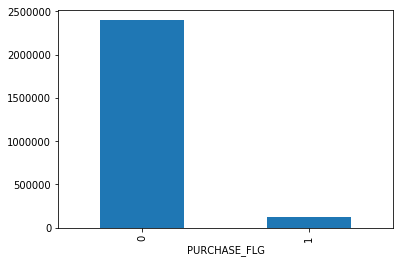

In [35]:
#With this graph we can see we have an imbalanced dataset  
user_visit_coupon.groupby(['PURCHASE_FLG']).size().plot.bar()

In [36]:
# Separate input features and target
y = user_visit_coupon.PURCHASE_FLG
X = user_visit_coupon.drop('PURCHASE_FLG', axis=1)

In [37]:
user_visit_coupon.shape

(2517206, 195)

In [38]:
# Testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

**Downsampling the data because the imbalance of the data**

In [39]:
# Data back together
X = pd.concat([X_train, y_train], axis=1)

In [40]:
# Separate minority and majority 
not_purchase = X[X.PURCHASE_FLG==0]
purchase = X[X.PURCHASE_FLG==1]

In [41]:
# Downsampled majority
purchase_downsampled = resample(not_purchase,
                          replace=False, # sample with replacement
                          n_samples=len(purchase), # match number in majority class
                          random_state=48) # reproducible results

In [42]:
downsampled = pd.concat([purchase, purchase_downsampled])
downsampled.PURCHASE_FLG.value_counts()

1    91691
0    91691
Name: PURCHASE_FLG, dtype: int64

In [43]:
downsampled.columns

Index(['CATALOG_PRICE', 'DISCOUNT_PRICE', 'DISPPERIOD', 'VALIDPERIOD',
       'USABLE_DATE_MON', 'USABLE_DATE_TUE', 'USABLE_DATE_WED',
       'USABLE_DATE_THU', 'USABLE_DATE_FRI', 'USABLE_DATE_SAT',
       ...
       'PREF_NAME_Tokushima Prefecture', 'PREF_NAME_Tokyo',
       'PREF_NAME_Tottori Prefecture', 'PREF_NAME_Toyama Prefecture',
       'PREF_NAME_Wakayama Prefecture', 'PREF_NAME_Yamagata Prefecture',
       'PREF_NAME_Yamaguchi Prefecture', 'PREF_NAME_Yamanashi Prefecture',
       'PREF_NAME_unknown', 'PURCHASE_FLG'],
      dtype='object', length=195)

In [44]:
y_train = downsampled.PURCHASE_FLG
X_train = downsampled.drop('PURCHASE_FLG', axis=1)

**Training the models **

In [45]:
#Logistic Regression model
model_LR = LogisticRegression(solver='lbfgs')
model_LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
pred_LR = model_LR.predict(X_test)

In [47]:
#Evaluating the Algorithm
# Checking accuracy
from sklearn.metrics import accuracy_score,f1_score, recall_score
accuracy_score(y_test, pred_LR)

0.5819225109724743

In [48]:
# f1 score
f1_score(y_test, pred_LR)

0.1280412022629428

In [49]:
#Recall
recall_score(y_test, pred_LR)

0.6292592351293244

In [50]:
 pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [51]:
##RandomForest Classifier  model
import joblib
RF = RandomForestClassifier(n_estimators=60, max_depth=2, random_state=27)
RF.fit(X_train, y_train)
# save model
joblib.dump(RF, 'model.pkl')

['model.pkl']

In [52]:
y_pred_rf = RF.predict(X_test)

In [53]:
#Evaluating the Algorithm
# Checking accuracy
accuracy_score(y_test, y_pred_rf)

0.6115489860194311

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))

[[367102 231502]
 [ 12951  17747]]
              precision    recall  f1-score   support

           0       0.97      0.61      0.75    598604
           1       0.07      0.58      0.13     30698

    accuracy                           0.61    629302
   macro avg       0.52      0.60      0.44    629302
weighted avg       0.92      0.61      0.72    629302



In [55]:
y_test.value_counts()

0    598604
1     30698
Name: PURCHASE_FLG, dtype: int64